# Explore here

In [265]:
import pandas as pd
import csv
import requests
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import missingno as msno
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

In [266]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
response = requests.get(url).content.decode('utf-8')

file_name = '/workspaces/machine-learning-python-template/data/raw/Airbnb.csv'

with open(file_name, 'w') as temp_file:
    temp_file.writelines(response)


In [267]:
df = pd.read_csv(file_name)
pd.set_option('display.max_columns', None)
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [268]:
#Obtenemos el tamaño completo para futuras comparaciones
df.shape

(48895, 16)

In [269]:
#Obtenemos los valores únicos para averiguar si hay algun valor a descartar, no hay.

n_unicos = df.nunique()
n_unicos

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [270]:
#Buscamos registros duplicados, no hay.
print(df.duplicated().sum())

#El único campo problemático en cuanto a duplicados es el id, y no tiene, el resto tiene sentido que se repitan, o se puedan repetir.
print(df["id"].duplicated().sum())

#Como el id no está repetido, y no aporta valor a las estadísticas, lo eliminamos
df.drop(['id'], axis=1, inplace=True)

0
0


In [271]:
# Comprobamos el porcentaje de anuncios que presentan al menos un valor faltante (el 20%)
print(df.isnull().any(axis=1).mean()*100)

20.603333674199817


In [272]:
# Revisamos los valores faltantes
print(df.isnull().mean()*100)


name                               0.032723
host_id                            0.000000
host_name                          0.042949
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       20.558339
reviews_per_month                 20.558339
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64


In [273]:
'''
Elimino la columna host_name, ya que tenemos host_id, al ser redundantes, ya que ambas significan la misma persona/empresa, 
y host_name tiene valores nulos y podrían darse valores repetidos.
Elimino la columna name al no ser relevante para las estadísticas, ya que varios anuncios podrían tener el mismo nombre.
Elimino las columnas latitud y longitud, ya que con el barrio y el grupo dentro del barrio son suficientemente precisas para sacar estadísticas 
dentro de los mismos, al tener todos una latitud y longitud únicas, se tienen información relativamente redundante y con una precisión innecesaria.
'''

df.drop(['host_name'], axis=1, inplace=True)
df.drop(['name'], axis=1, inplace=True)
df.drop(['latitude'], axis=1, inplace=True)
df.drop(['longitude'], axis=1, inplace=True)


In [274]:
df.head(10)

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,Private room,149,1,9,2018-10-19,0.21,6,365
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,4632,Manhattan,Harlem,Private room,150,3,0,NaN,NaN,1,365
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,7322,Manhattan,Murray Hill,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,7356,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,2017-10-05,0.40,1,0
7,8967,Manhattan,Hell's Kitchen,Private room,79,2,430,2019-06-24,3.47,1,220
8,7490,Manhattan,Upper West Side,Private room,79,2,118,2017-07-21,0.99,1,0
9,7549,Manhattan,Chinatown,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [275]:
print(df[["number_of_reviews","last_review","reviews_per_month"]].loc[df["number_of_reviews"] == 0])
print(df[["number_of_reviews","last_review","reviews_per_month"]].loc[df["number_of_reviews"] == 0].count())

       number_of_reviews last_review  reviews_per_month
2                      0         NaN                NaN
19                     0         NaN                NaN
26                     0         NaN                NaN
36                     0         NaN                NaN
38                     0         NaN                NaN
...                  ...         ...                ...
48890                  0         NaN                NaN
48891                  0         NaN                NaN
48892                  0         NaN                NaN
48893                  0         NaN                NaN
48894                  0         NaN                NaN

[10052 rows x 3 columns]
number_of_reviews    10052
last_review              0
reviews_per_month        0
dtype: int64


<Axes: >

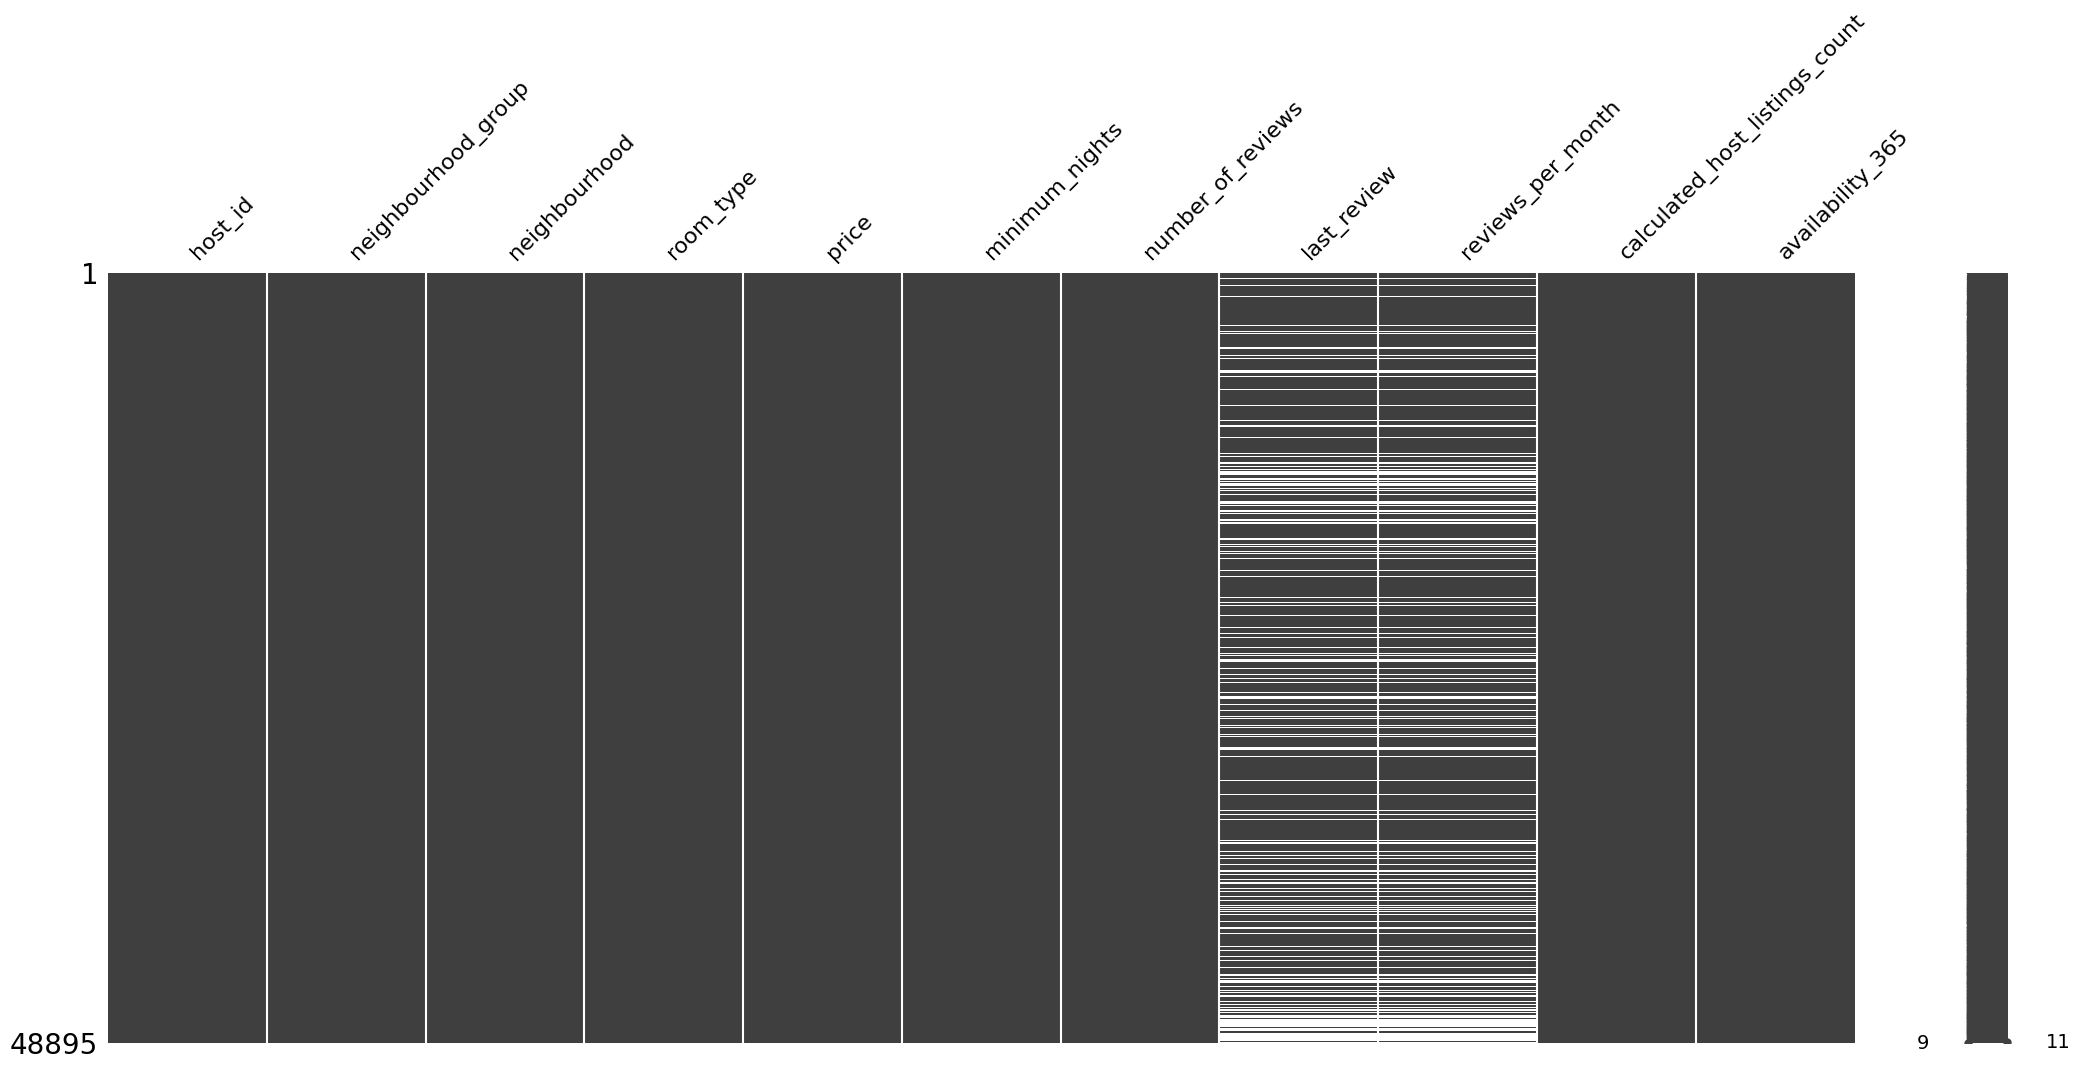

In [276]:
msno.matrix(df)

<Axes: >

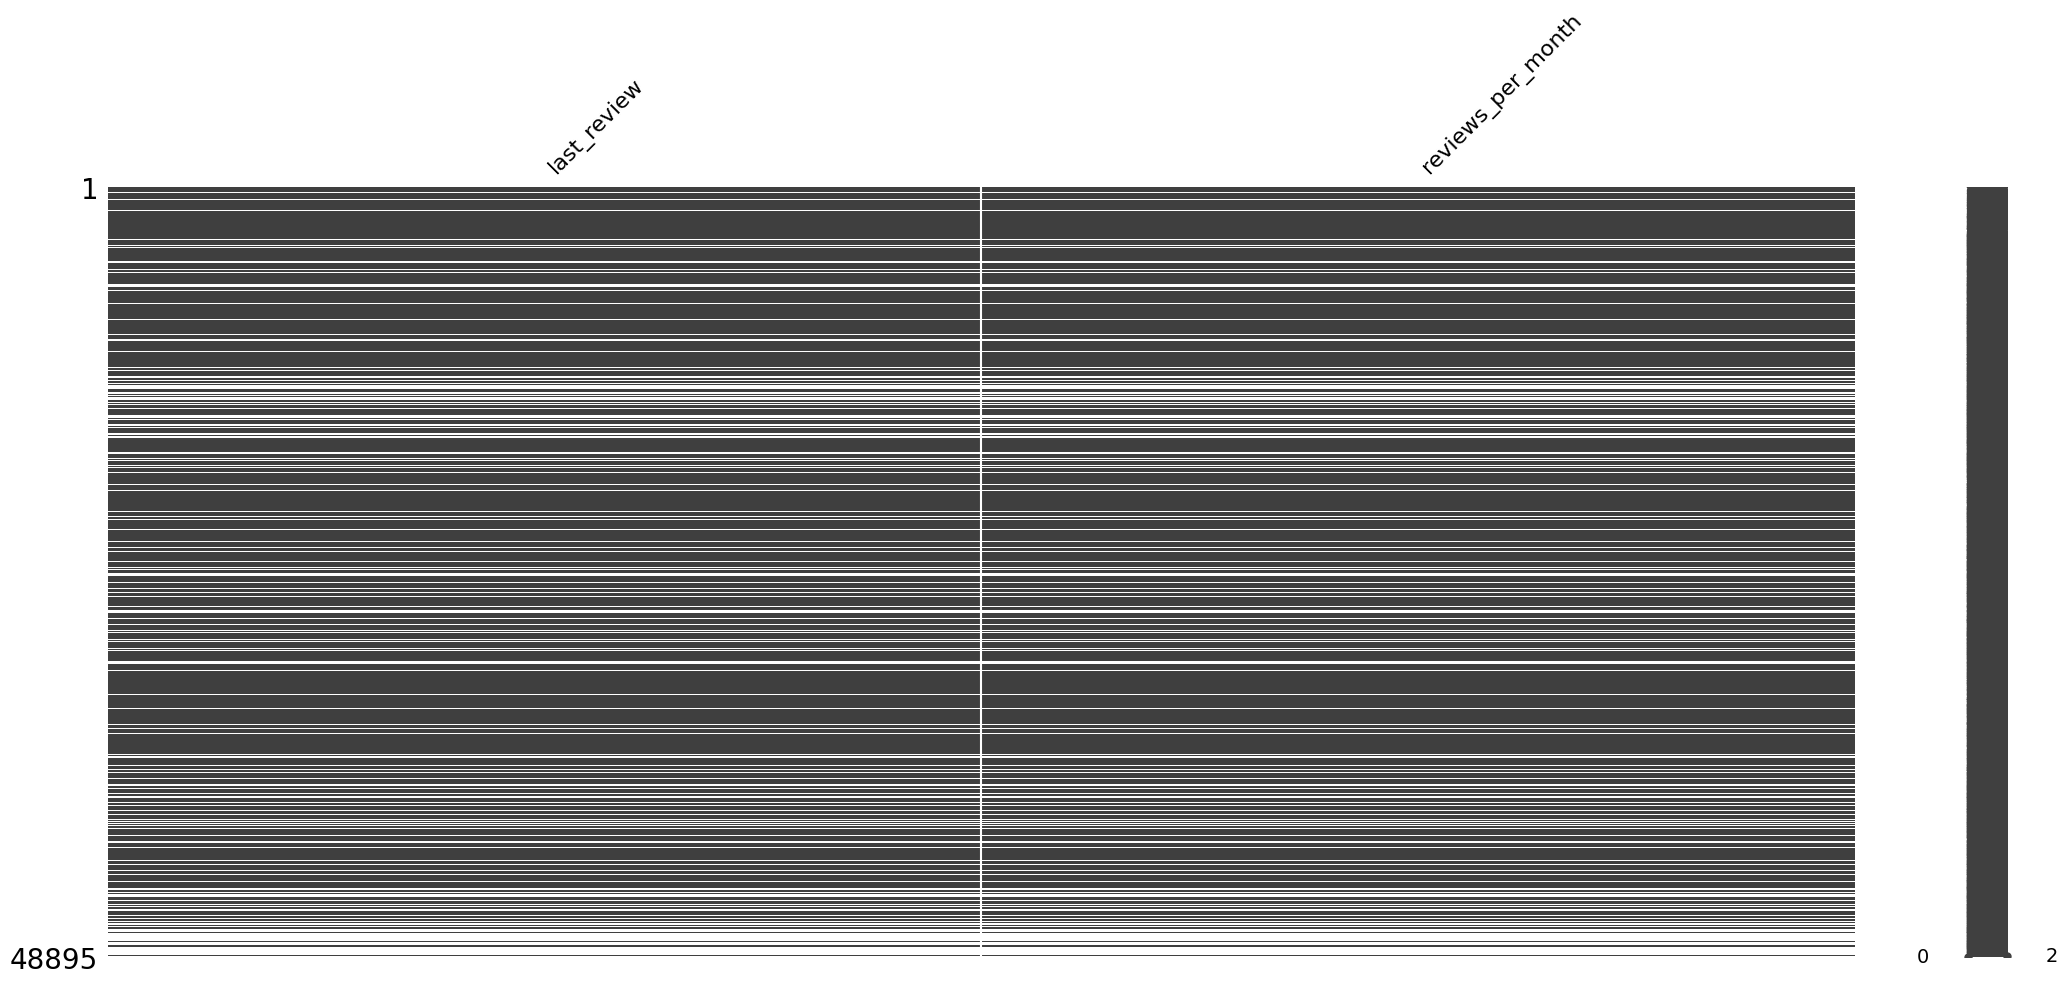

In [277]:
msno.matrix(df[["last_review","reviews_per_month"]])

In [278]:

'''
Podemos observar como las columnas de última reseña y reseñas por mes tienen valores NaN en el caso de que el número de reseñas sea cero, o NaN,
lo cual tiene sentido, que nos lo confirma también el gráfico msno.
Teniendo el número de reseñas, las columnas de reseñas por mes resulta poco relevante, al igual que la fecha de la última reserva, y además
al tener valores Nan, no podríamos contemplarlas en las estadísticas, así que las eliminamos.
'''

df.drop(['reviews_per_month'], axis=1, inplace=True)
df.drop(['last_review'], axis=1, inplace=True)


In [279]:

#Podemos observar como la quinta parte aproximadamente de las viviendas no tiene ninguna reseña
print(df["number_of_reviews"].loc[df["number_of_reviews"] == 0].count()/len(df)*100)


20.55833929849678


In [280]:
df.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,2787,Brooklyn,Kensington,Private room,149,1,9,6,365
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2,355
2,4632,Manhattan,Harlem,Private room,150,3,0,1,365
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   host_id                         48895 non-null  int64 
 1   neighbourhood_group             48895 non-null  object
 2   neighbourhood                   48895 non-null  object
 3   room_type                       48895 non-null  object
 4   price                           48895 non-null  int64 
 5   minimum_nights                  48895 non-null  int64 
 6   number_of_reviews               48895 non-null  int64 
 7   calculated_host_listings_count  48895 non-null  int64 
 8   availability_365                48895 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 3.4+ MB


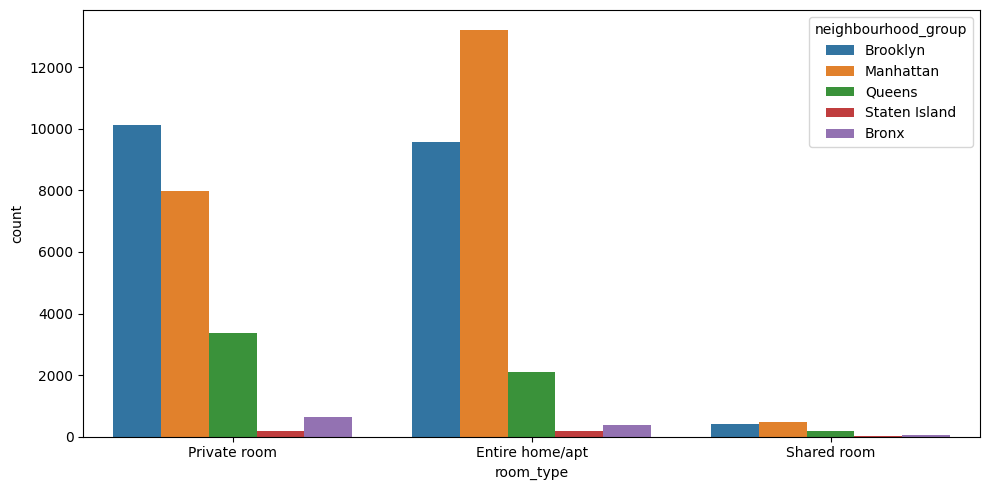

In [282]:
#Obtenemos los tipos de habitación por vecindario
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(data = df, x = "room_type", hue = "neighbourhood_group")

plt.tight_layout()

plt.show()

In [283]:
#Calculamos los valores medios en función del distrito.

price_neighbourhood_group_mean = pd.DataFrame(df['price'].groupby(df['neighbourhood_group']).median())
price_neighbourhood_group_mean['neighbourhood_group'] = list(price_neighbourhood_group_mean.index)
print(price_neighbourhood_group_mean)


                     price neighbourhood_group
neighbourhood_group                           
Bronx                 65.0               Bronx
Brooklyn              90.0            Brooklyn
Manhattan            150.0           Manhattan
Queens                75.0              Queens
Staten Island         75.0       Staten Island


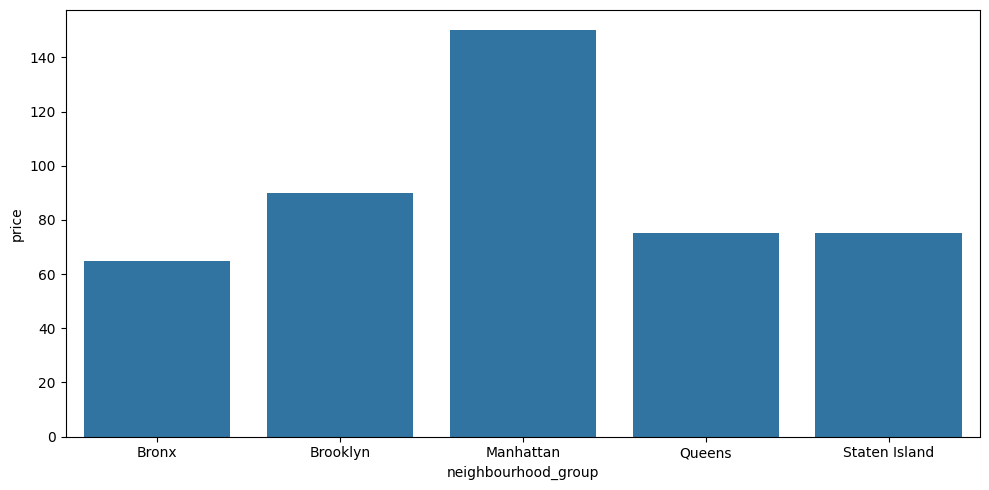

In [284]:
#Obtenemos los precios por distrito
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data = price_neighbourhood_group_mean, x = "neighbourhood_group", y = "price", fill = True)

plt.tight_layout()

plt.show()

In [285]:
print(df.describe())

'''
Se puede observar que en todos los campos hay un valor máximo muy por encima de la media y del percentil 75 en proporción,
lo cual nos indica que existen valores outliners.
'''

            host_id         price  minimum_nights  number_of_reviews  \
count  4.889500e+04  48895.000000    48895.000000       48895.000000   
mean   6.762001e+07    152.720687        7.029962          23.274466   
std    7.861097e+07    240.154170       20.510550          44.550582   
min    2.438000e+03      0.000000        1.000000           0.000000   
25%    7.822033e+06     69.000000        1.000000           1.000000   
50%    3.079382e+07    106.000000        3.000000           5.000000   
75%    1.074344e+08    175.000000        5.000000          24.000000   
max    2.743213e+08  10000.000000     1250.000000         629.000000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%

'\nSe puede observar que en todos los campos hay un valor máximo muy por encima de la media y del percentil 75 en proporción,\nlo cual nos indica que existen valores outliners.\n'

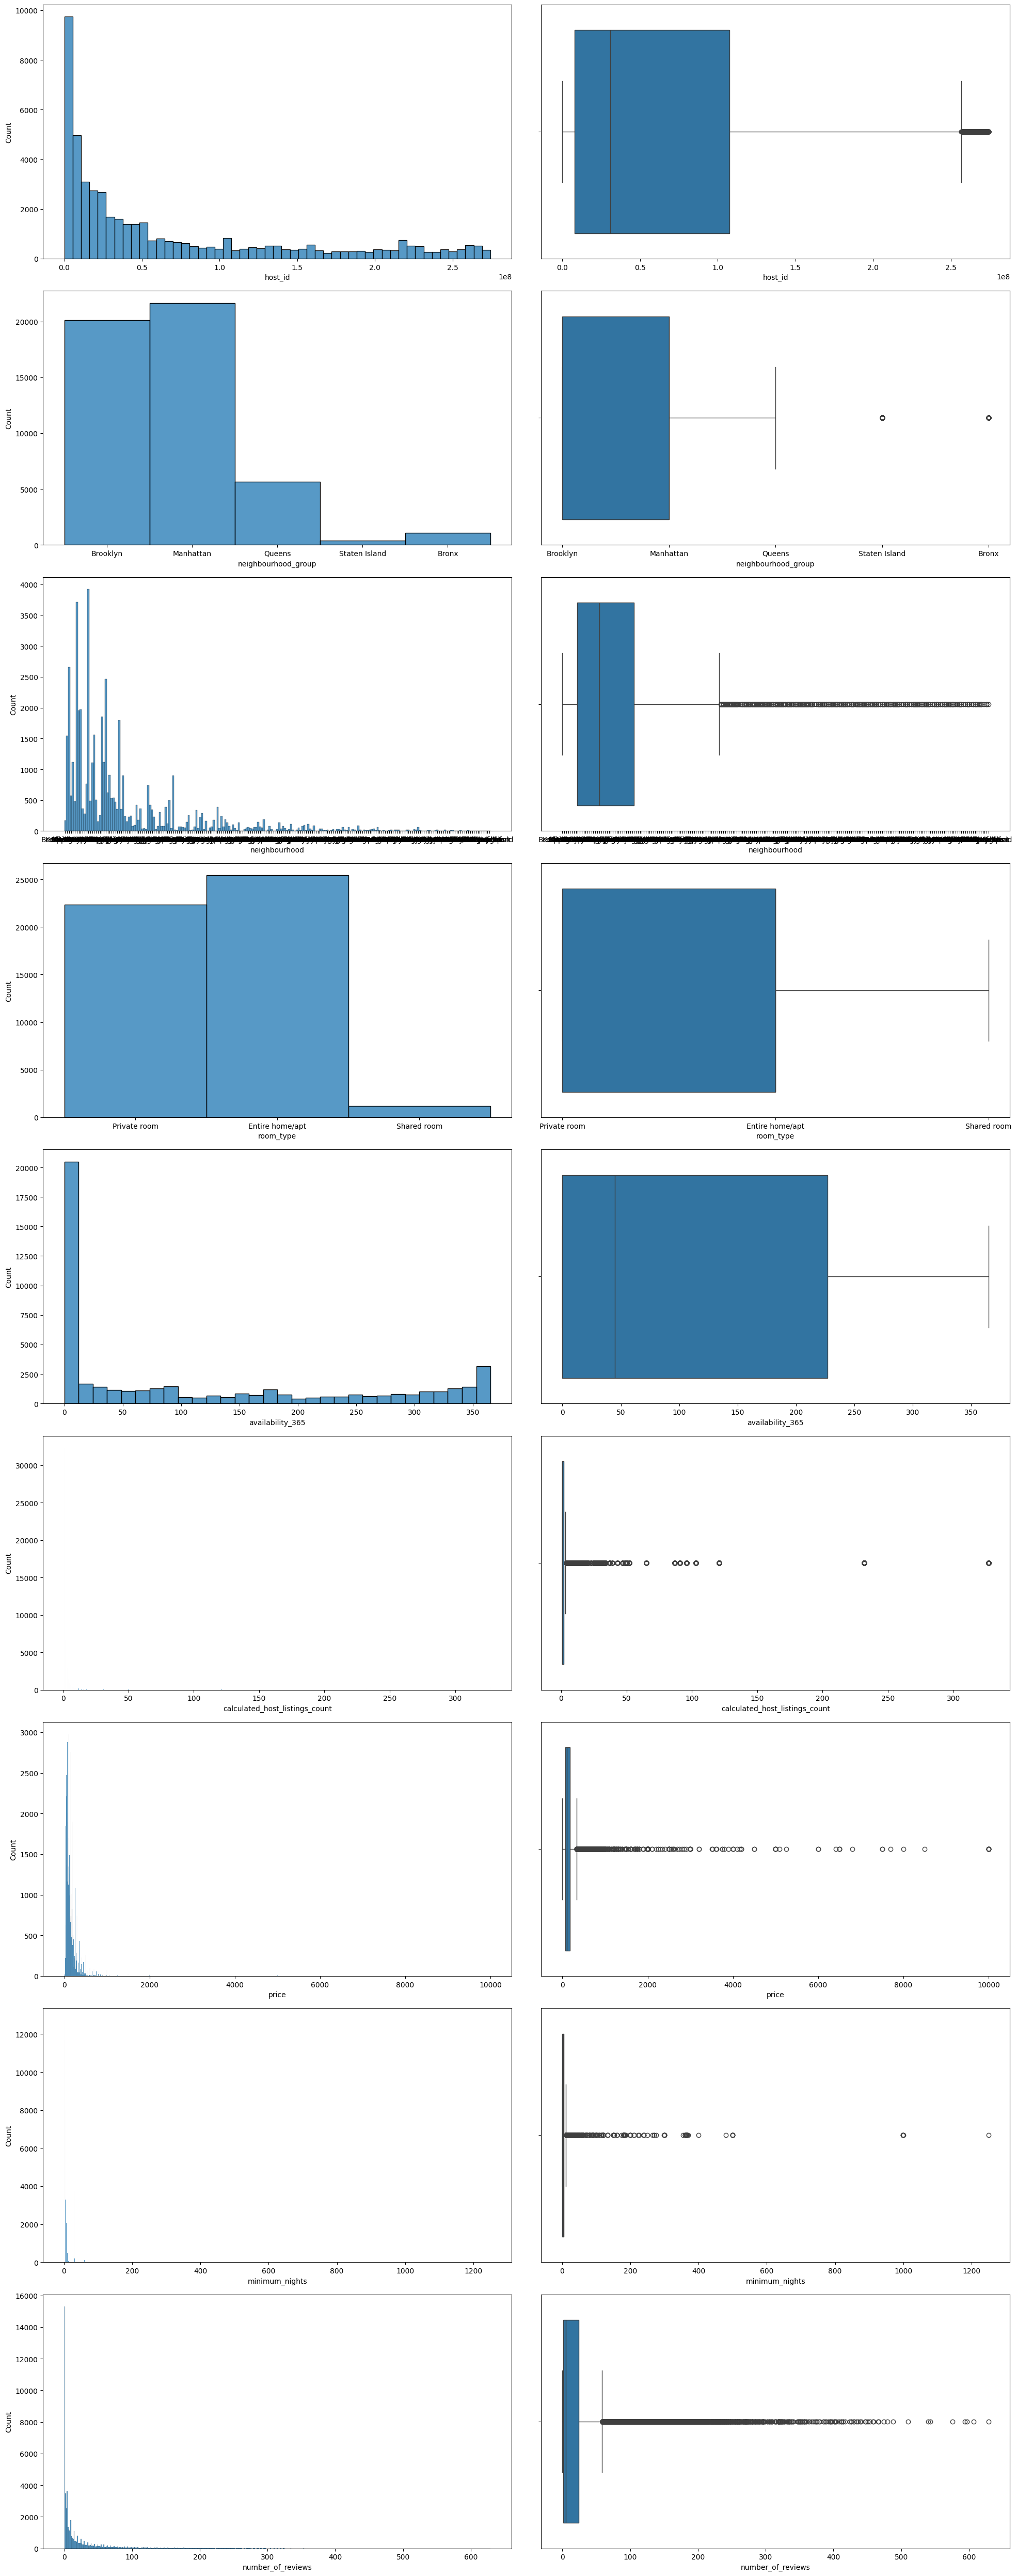

In [286]:
'''
Obtengo gráficas de todos los campos.
'''

fig, axis = plt.subplots(9, 2, figsize=(20, 50))

sns.histplot(ax = axis[0,0], data = df, x = "host_id")
sns.histplot(ax = axis[1,0], data = df, x = "neighbourhood_group")
sns.histplot(ax = axis[2,0], data = df, x = "neighbourhood")
sns.histplot(ax = axis[3,0], data = df, x = "room_type")
sns.histplot(ax = axis[4,0], data = df, x = "availability_365")
sns.histplot(ax = axis[5,0], data = df, x = "calculated_host_listings_count")
sns.histplot(ax = axis[6,0], data = df, x = "price")
sns.histplot(ax = axis[7,0], data = df, x = "minimum_nights")
sns.histplot(ax = axis[8,0], data = df, x = "number_of_reviews")

sns.boxplot(ax = axis[0,1], data = df, x = "host_id")
sns.boxplot(ax = axis[1,1], data = df, x = "neighbourhood_group")
sns.boxplot(ax = axis[2,1], data = df, x = "neighbourhood")
sns.boxplot(ax = axis[3,1], data = df, x = "room_type")
sns.boxplot(ax = axis[4,1], data = df, x = "availability_365")
sns.boxplot(ax = axis[5,1], data = df, x = "calculated_host_listings_count")
sns.boxplot(ax = axis[6,1], data = df, x = "price")
sns.boxplot(ax = axis[7,1], data = df, x = "minimum_nights")
sns.boxplot(ax = axis[8,1], data = df, x = "number_of_reviews")

plt.tight_layout()

plt.show()

De los gráficos obtenidos en base a los datos, aunque se puede observar que en la mayoría de los campos la mayoría de los valores se agrupan en un rango concreto, no considero outliners, o por lo menos no como valores a eliminar, los datos que se salen de este grupo, ya que es razonable que una vivienda tenga muchas más reseñas si lleva alquilandose mucho más tiempo que la media, o se alquila por temporadas más pequeñas por lo que al haber más número de clientes alquilandola por periodos breves, tendrá más clientes y más reseñas, en cuanto al precio, lo mismo, es totalmente razonable que haya viviendas más grandes, o más lujosas, que se salgan por mucho de la media de viviendas en precio.
En cuanto a disponibilidad, lo mismo, puede que algunas tengan ya reservas hechas, y puede que algunas no tengan ninguna, por lo que la disponibilidad es razonable que pase de 0 a 365, y todos son valores razonables en este escenario.
En cuanto al mínimo de noches, podemos observar que hay una muy minoría, casi valores puntuales, que tienen un mínimo de noches superiores al año, pero tampoco podemos descartar que sus dueños esten interesados en alquilarlas a largo plazo y por breves periodos vacacionales, por lo que de momento también las mantengo.

In [287]:
'''
Quiero sacar una columna del logaritmo de precio, pero al haber valores cero, el logaritmo de cero es infinito, así que modifico los registros que tengan valor cero por un valor distinto 
de cero, para que el logaritmo no de un valor infinito.
'''

print(df[df["price"]==0].count())

print(df[df["price"]==0])


host_id                           11
neighbourhood_group               11
neighbourhood                     11
room_type                         11
price                             11
minimum_nights                    11
number_of_reviews                 11
calculated_host_listings_count    11
availability_365                  11
dtype: int64
         host_id neighbourhood_group       neighbourhood        room_type  \
23161    8993084            Brooklyn  Bedford-Stuyvesant     Private room   
25433  131697576               Bronx     East Morrisania     Private room   
25634   15787004            Brooklyn            Bushwick     Private room   
25753    1641537            Brooklyn          Greenpoint     Private room   
25778   10132166            Brooklyn        Williamsburg  Entire home/apt   
25794   86327101            Brooklyn  Bedford-Stuyvesant     Private room   
25795   86327101            Brooklyn  Bedford-Stuyvesant     Private room   
25796   86327101            Brooklyn  

In [288]:
df.loc[df["price"] == 0 , 'price'] = int(1)

In [290]:
#print(df.head())

print(df[df["price"]==1].count())
print(df[df["price"]==0].count())


host_id                           11
neighbourhood_group               11
neighbourhood                     11
room_type                         11
price                             11
minimum_nights                    11
number_of_reviews                 11
calculated_host_listings_count    11
availability_365                  11
dtype: int64
host_id                           0
neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


In [291]:
#Creo la columna log_price para acercar el precio a una distribución normal

df['log_price'] = np.log(df['price'])


In [292]:
df.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price
0,2787,Brooklyn,Kensington,Private room,149,1,9,6,365,5.003946
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2,355,5.416100
2,4632,Manhattan,Harlem,Private room,150,3,0,1,365,5.010635
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194,4.488636
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0,4.382027


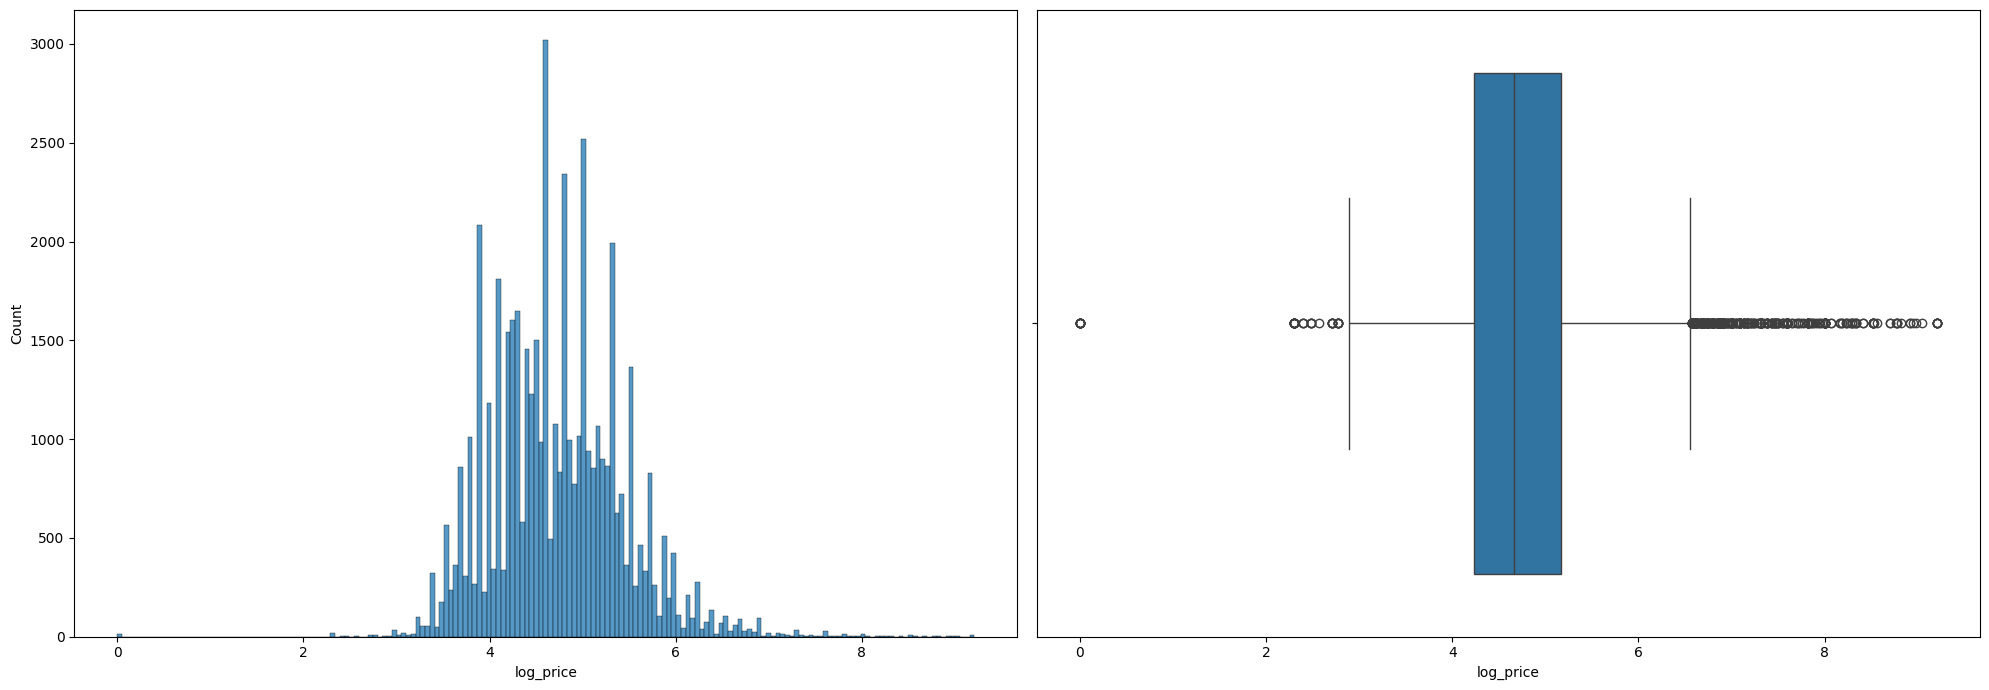

In [293]:
fig, axis = plt.subplots(1, 2, figsize=(20, 7))

sns.histplot(ax = axis[0], data = df, x = "log_price")
sns.boxplot(ax = axis[1], data = df, x = "log_price")

plt.tight_layout()
plt.show()


['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


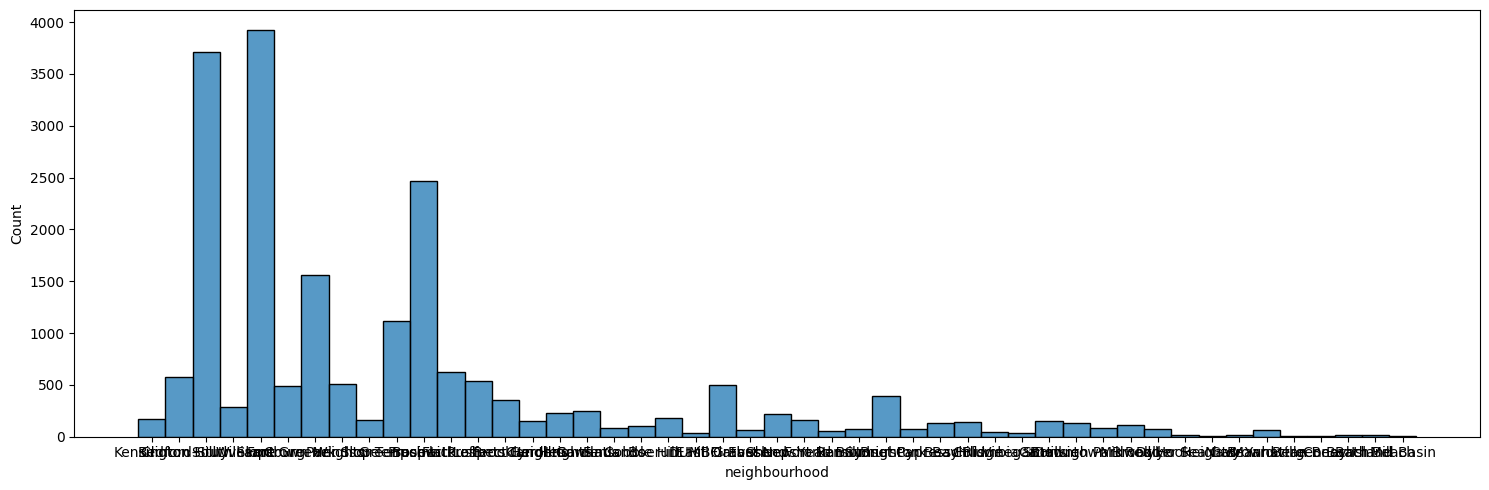

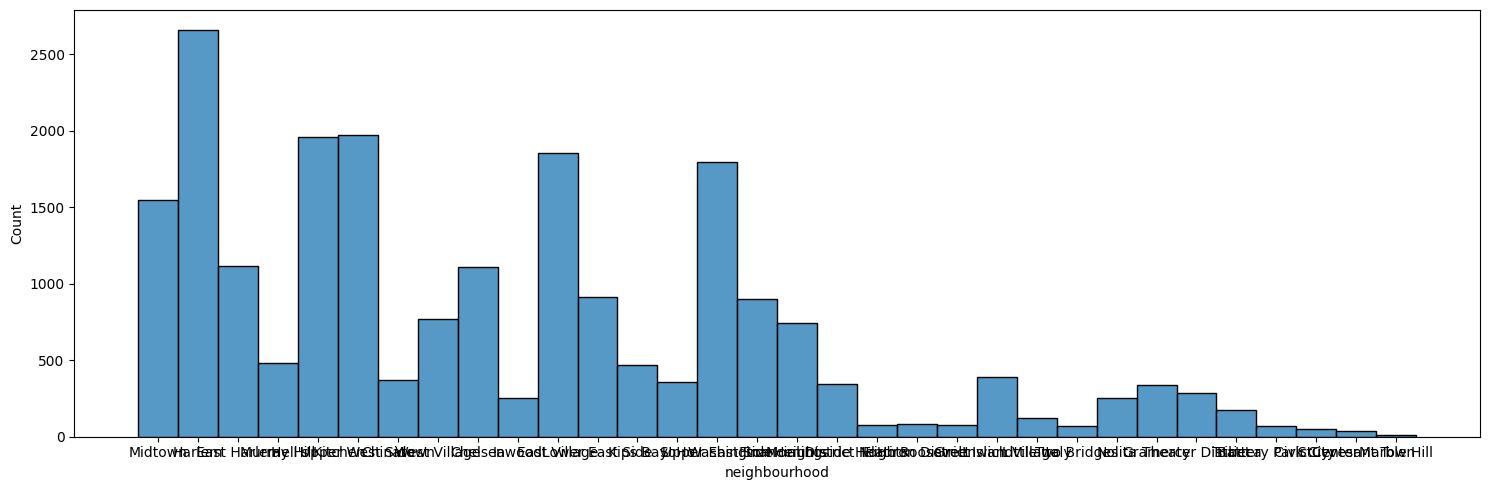

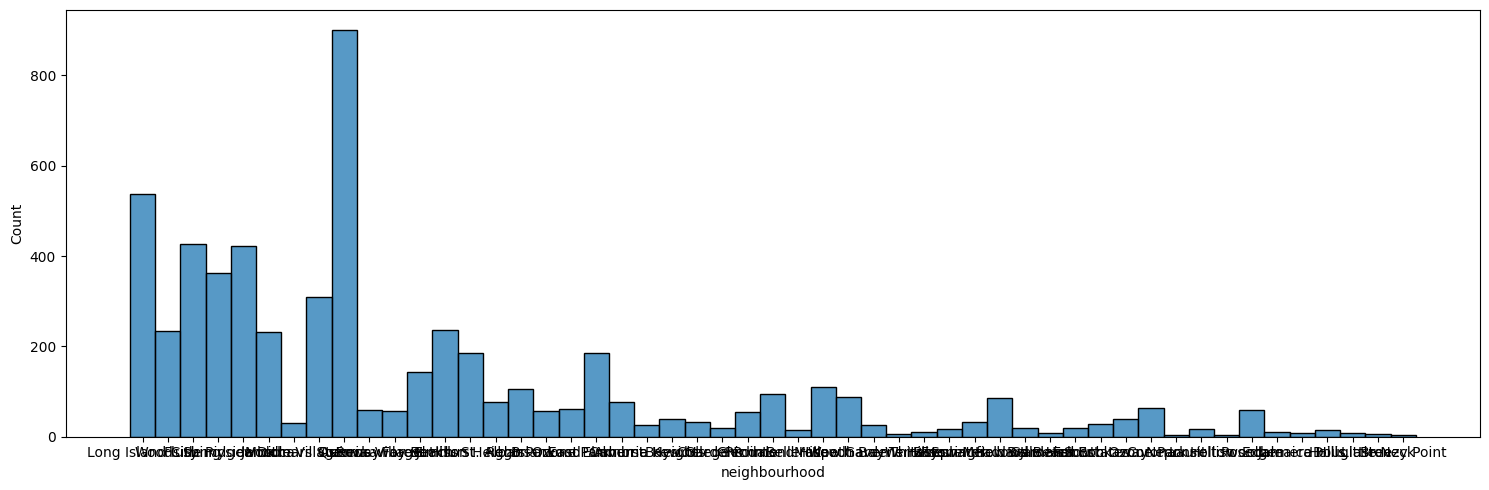

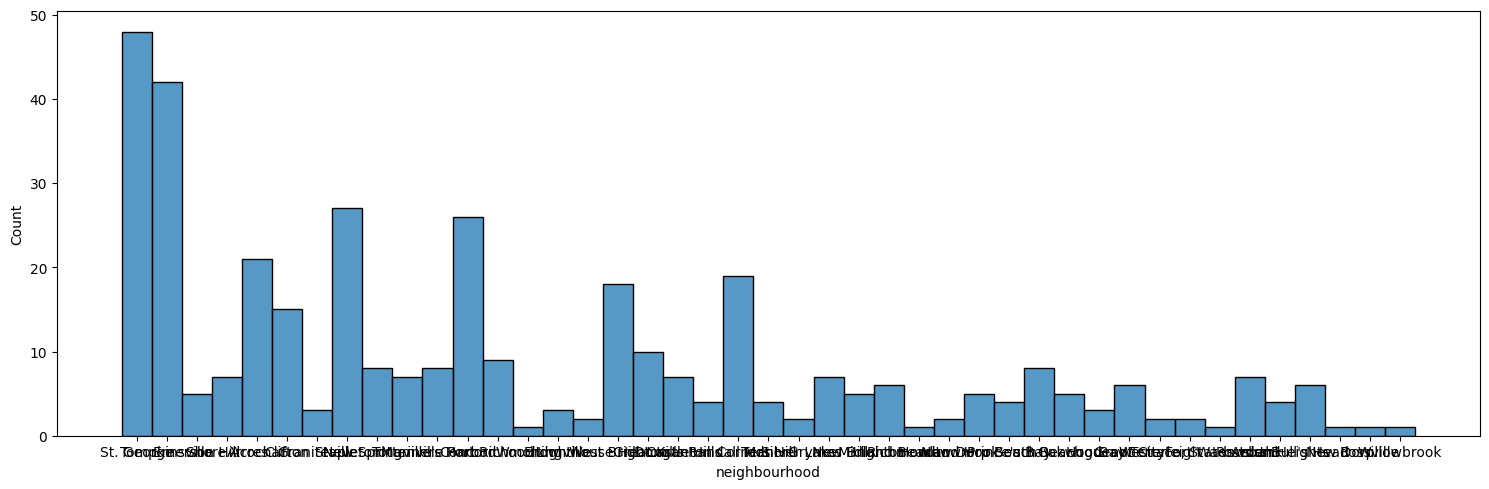

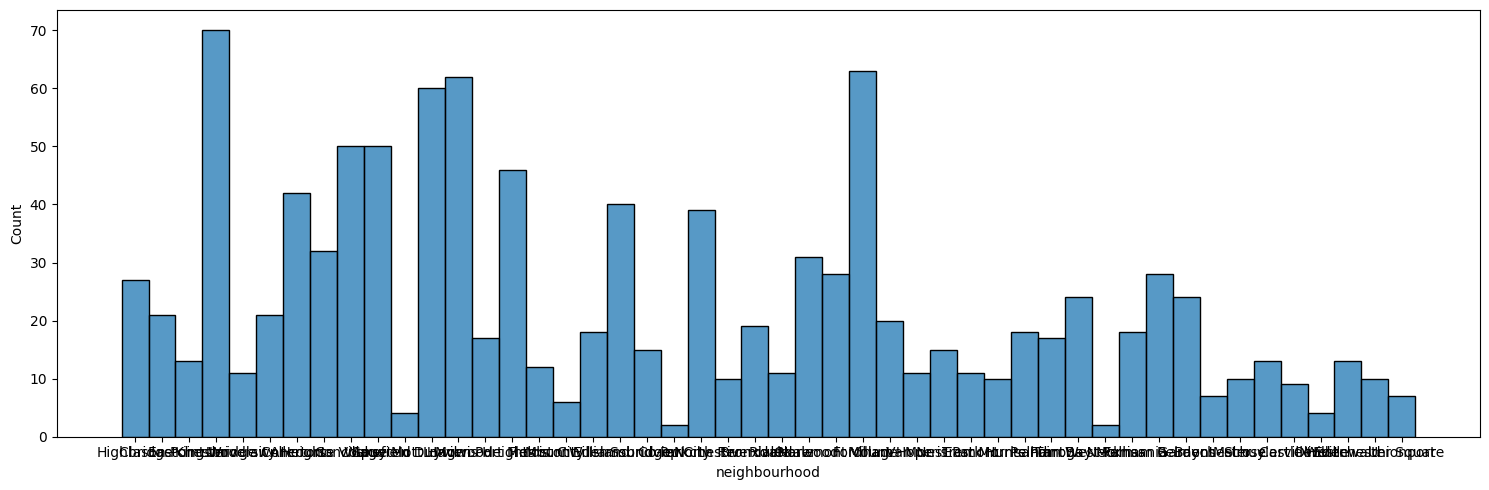

In [294]:
#Obtengo los distintos grupos de vecindarios
print(df["neighbourhood_group"].unique())

#Genero dataframes con sus vecindarios
Brooklyn = df[["neighbourhood","price"]].loc[df["neighbourhood_group"] == "Brooklyn"]
Manhattan = df[["neighbourhood","price"]].loc[df["neighbourhood_group"] == "Manhattan"]
Queens = df[["neighbourhood","price"]].loc[df["neighbourhood_group"] == "Queens"]
Staten_Island = df[["neighbourhood","price"]].loc[df["neighbourhood_group"] == "Staten Island"]
Bronx = df[["neighbourhood","price"]].loc[df["neighbourhood_group"] == "Bronx"]


fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data = Brooklyn, x = "neighbourhood")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data = Manhattan, x = "neighbourhood")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data = Queens, x = "neighbourhood")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data = Staten_Island, x = "neighbourhood")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data = Bronx, x = "neighbourhood")
plt.tight_layout()
plt.show()





In [295]:
df.head()

,host_id,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price
0,2787,Brooklyn,Kensington,Private room,149,1,9,6,365,5.003946
1,2845,Manhattan,Midtown,Entire home/apt,225,1,45,2,355,5.416100
2,4632,Manhattan,Harlem,Private room,150,3,0,1,365,5.010635
3,4869,Brooklyn,Clinton Hill,Entire home/apt,89,1,270,1,194,4.488636
4,7192,Manhattan,East Harlem,Entire home/apt,80,10,9,1,0,4.382027


In [326]:
'''
Factorizo la variable de room type de menor número a mayor en función del peso que tienen (el apartamento entero siendo la mayor y la 
habitación compartida la menor)
'''
print(df["room_type"].unique())

['Private room' 'Entire home/apt' 'Shared room']


In [327]:

df.loc[df["room_type"] == "Shared room" , 'room_type_f'] = int(1)
df.loc[df["room_type"] == "Private room" , 'room_type_f'] = int(2)
df.loc[df["room_type"] == "Entire home/apt" , 'room_type_f'] = int(3)


In [300]:
#Factorizo las variables de distrito y vecindario en función de su frecuencia de aparición

for location in df["neighbourhood"].unique():
    df.loc[df["neighbourhood"] == location, 'neighbourhood_f'] = df['neighbourhood'].value_counts().get(location, 0)/len(df)*100

for location in df["neighbourhood_group"].unique():
    df.loc[df["neighbourhood_group"] == location, 'neighbourhood_group_f'] = df['neighbourhood_group'].value_counts().get(location, 0)/len(df)*100

In [329]:
df.head()

,host_id,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,room_type_f,neighbourhood_f
0,2787,Kensington,Private room,149,1,9,6,365,5.003946,2.0,0.357910
1,2845,Midtown,Entire home/apt,225,1,45,2,355,5.416100,3.0,3.159832
2,4632,Harlem,Private room,150,3,0,1,365,5.010635,2.0,5.436139
3,4869,Clinton Hill,Entire home/apt,89,1,270,1,194,4.488636,3.0,1.169854
4,7192,East Harlem,Entire home/apt,80,10,9,1,0,4.382027,3.0,2.284487


In [302]:
#Factorizo las variables de los vecindarios usando la función factorize, ya que un barrio u otro no tienen mayor o menor peso

#df["neighbourhood_group_f"] = pd.factorize(df["neighbourhood_group"])[0]
#df["neighbourhood_f"] = pd.factorize(df["neighbourhood"])[0]

KeyError: "['neighbourhood_group_f'] not in index"

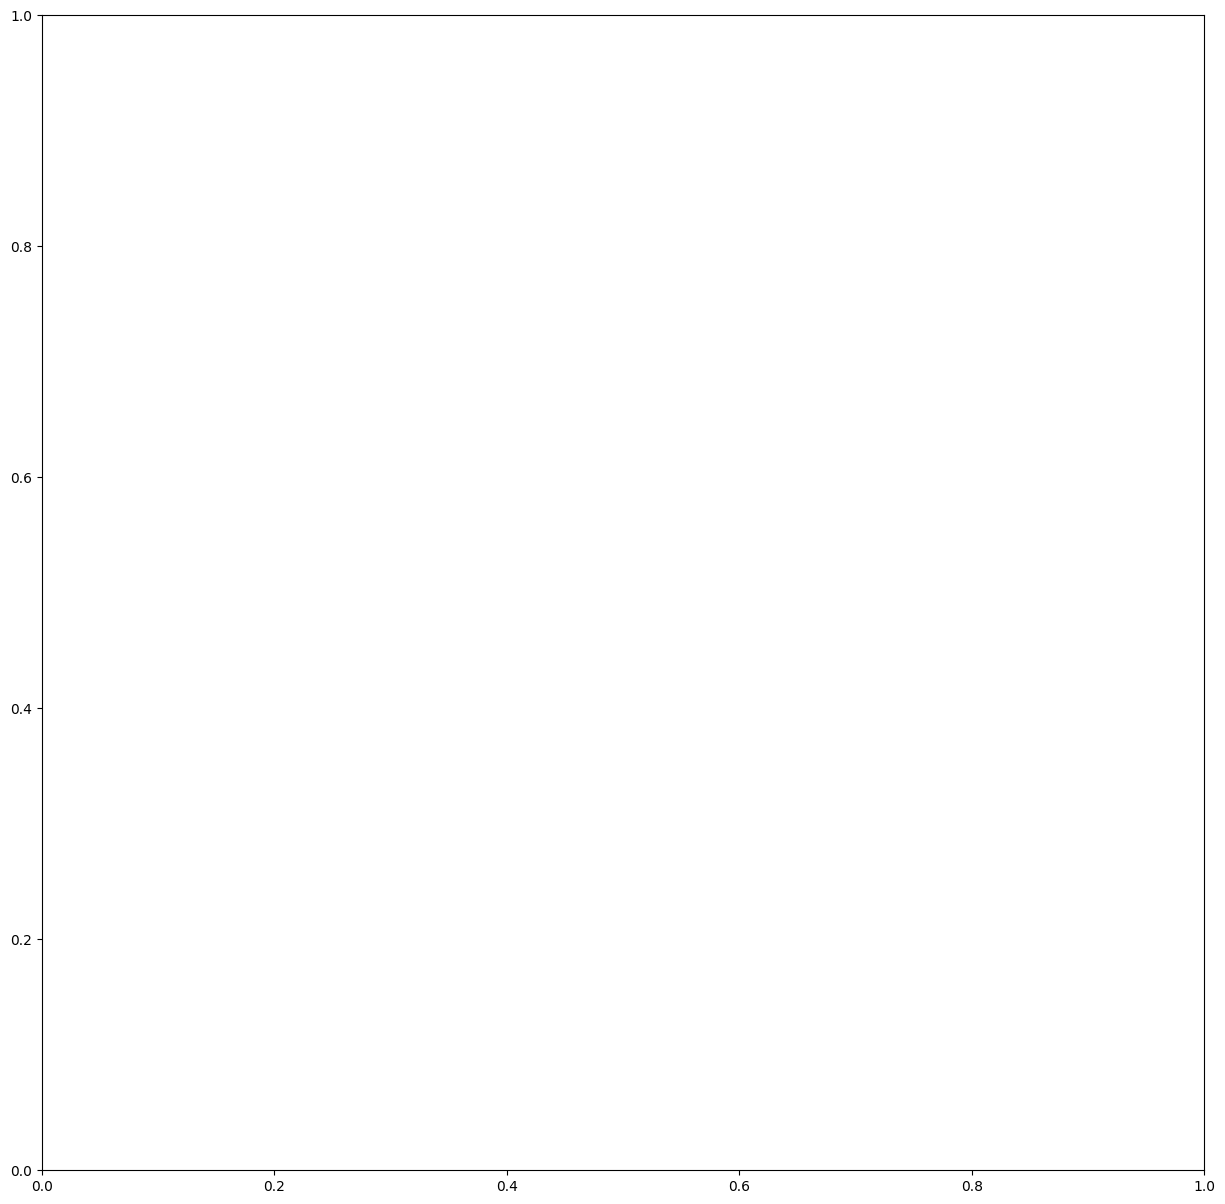

In [330]:

fig, axes = plt.subplots(figsize=(15, 15))

sns.heatmap(df[["neighbourhood_group_f", "neighbourhood_f", "room_type_f", "price", "minimum_nights",	
                        "number_of_reviews", "calculated_host_listings_count", "availability_365"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()
plt.show()

Vemos que hay una correlación bastante alta entre neighbourhood y neighbourhood group, lo cual tiene sentido, ya que los vecindarios son parte de
los distritos, por lo que tendría cierto sentido eliminar los distritos, ya que el un vecindario está univocamente asociado a un distrito y no a otro, y es más específico, por lo que elimino el campo de distrito para los cálculos, ya que se puede observar en las gráficas que aunque el precio medio de Manhatan es el más caro, un barrio concreto de Brooklyn puede ser mucho más caro que otro de Manhatan, con lo cual es un valor más objetivo, claro y preciso que el distrito en sí, ya que los precios varían mucho por vecindario.

In [304]:

df.drop(['neighbourhood_group'], axis=1, inplace=True)
df.drop(['neighbourhood_group_f'], axis=1, inplace=True)

'''

df.drop(['room_type_f'], axis=1, inplace=True)
df.drop(['neighbourhood_f'], axis=1, inplace=True)

'''

"\n\ndf.drop(['room_type_f'], axis=1, inplace=True)\ndf.drop(['neighbourhood_f'], axis=1, inplace=True)\n\n"

In [337]:
#Separamos la variable dependiente de las independientes (y las variables no factorizadas)
X = df.drop(['price','room_type','neighbourhood','log_price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.head()

,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_f,neighbourhood_f
0,2787,1,9,6,365,2.0,0.357910
1,2845,1,45,2,355,3.0,3.159832
2,4632,3,0,1,365,2.0,5.436139
3,4869,1,270,1,194,3.0,1.169854
4,7192,10,9,1,0,3.0,2.284487


In [338]:
# Ajusta un modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

print(cooks_distance[0])



[5.81755099e-09 8.35225271e-08 1.31031844e-08 ... 1.13881714e-06
 3.20366953e-06 4.00260685e-11]


In [339]:
X.head()

,const,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_f,neighbourhood_f
0,1.0,2787,1,9,6,365,2.0,0.357910
1,1.0,2845,1,45,2,355,3.0,3.159832
2,1.0,4632,3,0,1,365,2.0,5.436139
3,1.0,4869,1,270,1,194,3.0,1.169854
4,1.0,7192,10,9,1,0,3.0,2.284487


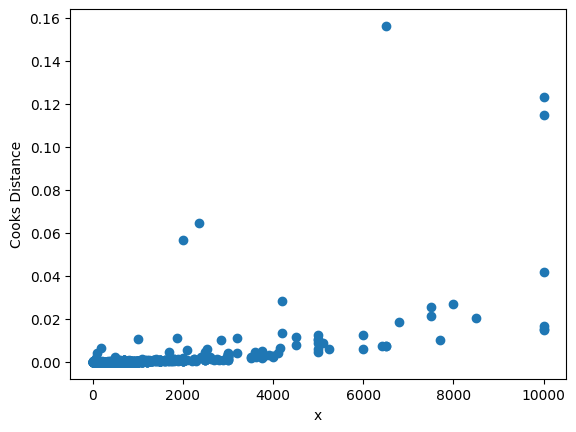

In [340]:
plt.scatter(df.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [341]:
print(np.where(cooks_distance[0]>0.04))

(array([ 9151, 12342, 17811, 40433, 44429, 48043]),)


In [311]:
df.iloc[[9151,12342,17811,44429,48043],]


,host_id,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,room_type_f,neighbourhood_f
9151,20582832,Astoria,Private room,10000,100,2,1,0,9.210340,2.0,1.840679
12342,3906464,Lower East Side,Private room,9999,99,6,1,83,9.210240,2.0,1.863176
17811,41870118,Forest Hills,Entire home/apt,2350,365,0,1,364,7.762171,3.0,0.294509
44429,9295237,Astoria,Private room,2000,365,0,2,0,7.600902,2.0,1.840679
48043,271248669,Tribeca,Entire home/apt,6500,180,0,1,365,8.779557,3.0,0.362000


In [312]:
# Punto de corte para la distancia de cook
pto_corte = 4/len(df)

print(pto_corte)

# Viviendas por encima del pto de corte
#print((np.where(cooks_distance[0]>pto_corte)[0]))

df1 = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

8.180795582370386e-05


In [313]:
print(len(df1))
print(len(df))

46990
48895


In [343]:
#Separamos la variable dependiente de las independientes (y las variables no factorizadas) con el nuevo dataframe 
X = df1.drop(['price','room_type','neighbourhood','log_price'], axis=1)
y = df1['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [342]:
# Usamos xgb para conocer la importancia de las características
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train, y_train)
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100})
df_imp = df_imp.sort_values(by='Importance', ascending=False)
print(df_imp)


'''
Todas las características tienen más de un 1%, ya que dudaba de la importancia del host_id, pero al superarla, aunque por poco, la mantengo.
'''

                          Feature  Importance
5                     room_type_f   25.801641
3  calculated_host_listings_count   17.067144
0                         host_id   15.500094
1                  minimum_nights   13.245502
2               number_of_reviews   10.060283
6                 neighbourhood_f    9.918268
4                availability_365    8.407064


'\nTodas las características tienen más de un 1%, ya que dudaba de la importancia del host_id, pero al superarla, aunque por poco, la mantengo.\n'

In [316]:
#VIF

X_train.corr()

,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_f,neighbourhood_f
host_id,1.000000,-0.021297,-0.128037,0.121381,0.192833,-0.102134,-0.104772
minimum_nights,-0.021297,1.000000,-0.107692,0.205253,0.190621,0.098447,-0.002493
number_of_reviews,-0.128037,-0.107692,1.000000,-0.068259,0.188014,0.000566,0.008218
calculated_host_listings_count,0.121381,0.205253,-0.068259,1.000000,0.220716,0.096740,-0.060950
availability_365,0.192833,0.190621,0.188014,0.220716,1.000000,-0.034278,-0.094985
room_type_f,-0.102134,0.098447,0.000566,0.096740,-0.034278,1.000000,-0.038230
neighbourhood_f,-0.104772,-0.002493,0.008218,-0.060950,-0.094985,-0.038230,1.000000


In [317]:
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns)
vif

host_id                           1.466425
minimum_nights                    1.487112
number_of_reviews                 1.467431
calculated_host_listings_count    1.501222
availability_365                  1.974070
room_type_f                       1.143612
neighbourhood_f                   1.088544
dtype: float64

<Axes: >

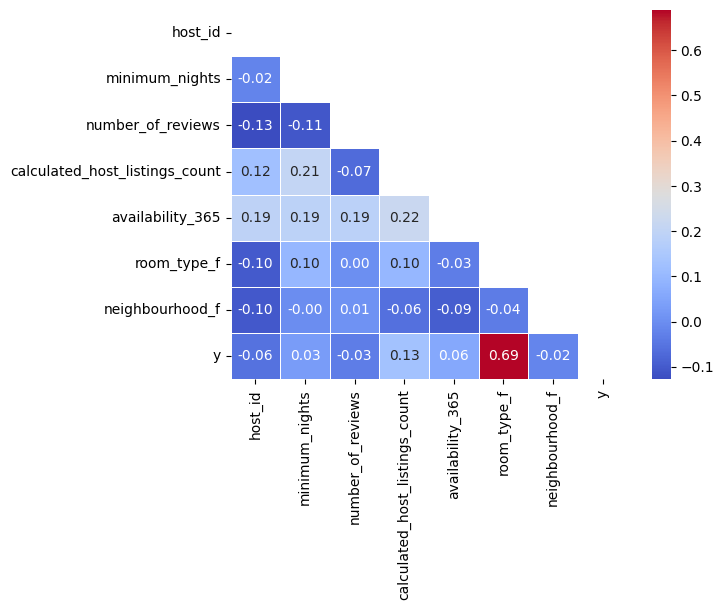

In [318]:
X_corr = X_train.copy()
X_corr['y'] = y_train
corr = X_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

In [319]:
#Escalado

# Identificar las variables binarias
binary_cols = X_train[(X_train == 0)|(X_train == 1)].dropna(axis=1).columns
binary_cols

#No hay columnas binarias

Index([], dtype='object')

In [320]:
#Al no haber columnas binarias, todas son variables numéricas

In [321]:
# Instancio la clase del escalador y lo ajusto con los datos de entrenamiento
scaler = MinMaxScaler().fit(X_train)

In [322]:
# Trasnformamos los datos numericos con el escalador ajustado
X_train_total_sc = scaler.transform(X_train)
X_test_total_sc = scaler.transform(X_test)

In [323]:
X_train_sc = pd.DataFrame(X_train_total_sc, columns = X_train.columns)
X_test_sc = pd.DataFrame(X_test_total_sc, columns = X_test.columns)

In [324]:
X_train_sc

,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,room_type_f,neighbourhood_f
0,0.012295,0.002004,0.076312,0.000000,0.635616,0.5,0.001786
1,0.059267,0.008016,0.000000,0.000000,0.000000,0.5,0.472570
2,0.022025,0.000000,0.000000,0.000000,0.000000,1.0,0.393978
3,0.333347,0.000000,0.259141,0.000000,0.279452,0.5,0.073233
4,0.665177,0.004008,0.001590,0.000000,0.178082,1.0,0.128859
...,...,...,...,...,...,...,...
37587,0.026931,0.010020,0.000000,0.000000,0.000000,0.5,1.000000
37588,0.070359,0.058116,0.000000,0.110429,0.000000,0.5,0.060219
37589,0.716725,0.058116,0.000000,0.003067,0.602740,0.5,0.947436
37590,0.006121,0.028056,0.014308,0.000000,0.520548,1.0,0.093646
